## Work on real Merian image
Several updates:


In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, hstack, vstack
from astropy.coordinates import SkyCoord
from astropy.visualization import make_lupton_rgb
from astropy.utils.data import download_file, clear_download_cache

import kuaizi
from kuaizi.display import display_single, SEG_CMAP
from kuaizi.download import download_decals_cutout
from kuaizi import DECaLS_pixel_scale, DECaLS_zeropoint
from kuaizi.detection import Data
# from kuaizi.utils import padding_PSF

import pickle
from IPython.display import clear_output

In [2]:
kuaizi.set_env(project='Merian', name='', data_dir='/scratch/gpfs/jiaxuanl/Data')

'/scratch/gpfs/jiaxuanl/Data/Merian/'

In [3]:
obj_cat = Table.read('./Cutout/stars/stars-2022-06-26.fits')
obj_cat['id'] = obj_cat['name']

In [4]:
gaap_cat = Table.read('./Catalogs/t9813_deep_native/hsc_merian_joint_native_pts.fits')[:500]
# flag = (gaap_cat['N708_blendedness_flag'] | gaap_cat['y_gaapOptimalFlux_flag_bigPsf'])
# gaap_cat = gaap_cat[~flag]
for aper in ['1p0', '1p5', '2p5', '3p0', 'Optimal']:
    gaap_cat[f'gaap_mag_{aper}'] = np.hstack(
        [31 - 2.5 * np.log10(gaap_cat[f'{filt}_gaap{aper}Flux'].data[:, None]
                            ) for filt in list('grizy') + ['N708', 'N540']])
gaap_cat[f'psf_mag'] = np.hstack(
        [31 - 2.5 * np.log10(gaap_cat[f'{filt}_psfFlux'].data[:, None]
                            ) for filt in list('grizy') + ['N708', 'N540']])
gaap_cat[f'cmodel_mag'] = np.hstack(
        [31 - 2.5 * np.log10(gaap_cat[f'{filt}_cModelFlux'].data[:, None]
                            ) for filt in list('grizy') + ['N708', 'N540']])

In [5]:
for aper in ['1p0', '1p5', '2p5', '3p0', 'Optimal']:
    obj_cat[f'gaap_mag_{aper}'] = gaap_cat[f'gaap_mag_{aper}']
obj_cat['psf_mag'] = gaap_cat[f'psf_mag']
obj_cat['cmodel_mag'] = gaap_cat[f'cmodel_mag']

### Step-by-step

165, 193, 201, 259, 286, 296, 312, 396,
        449, 484]),)

In [16]:
import sys
import copy
sys.path.append('/home/jiaxuanl/software/astrometry.net-0.89')
sys.path.append('/home/jiaxuanl/Research/Packages/tractor/')
sys.path.append('/home/jiaxuanl/Research/Packages/kuaizi/')
from kuaizi.tractor.fit import tractor_hsc_sep_blob_by_blob
from kuaizi.tractor.utils import getTargetProperty

array([109, 162, 163, 252, 487, 488])

In [38]:
def padding_PSF(psf_hdu):
    '''
    If the sizes of HSC PSF in all bands are not the same, this function pads the smaller PSFs.
    
    The output size must be odd.
    
    
    Parameters:
        psf_list: a list returned by `unagi.task.hsc_psf` function

    Returns:
        psf_pad: a list including padded PSFs. They now share the same size.
    '''
    # Padding PSF cutouts from HSC
    max_len = max(psf_hdu[0].data.shape)
    if max_len % 2 == 0:
        max_len += 1

    y_len, x_len = psf_hdu[0].data.shape
    dy = ((max_len - y_len) // 2, (max_len - y_len) // 2)
    dx = ((max_len - x_len) // 2, (max_len - x_len) // 2)
    
    if (max_len - y_len) == 1:
        dy = (1, 0)
    if (max_len - x_len) == 1:
        dx = (1, 0)
        
    temp = np.pad(psf_hdu[0].data.astype('float'), 
                  (dy, dx), 'constant', constant_values=0)
    
    if temp.shape == (max_len, max_len):
        return temp
    else:
        raise ValueError('Wrong size!')

In [39]:
channels = list('grizy') + ['N708', 'N540']

hsc_channels = [key for key in channels if not 'N' in key]
merian_channels = [key for key in channels if 'N' in key]
    
obj = obj_cat[0]
obj_id = obj['id']

#### HSC ####
cutout = []
for filt in hsc_channels:
    cutout.append(fits.open(os.path.join(obj['dir'], f"{obj['prefix']}_{filt}_deepCoadd_calexp.fits")))
psf_list = []
for filt in hsc_channels:
    psf_list.append(fits.open(os.path.join(obj['dir'], f"{obj['prefix']}_{filt}_psf.fits")))

images = np.array([hdu[1].data for hdu in cutout if len(hdu) > 1])
w = wcs.WCS(cutout[0][1].header) # note: all bands share the same WCS here
weights = 1 / np.array([hdu[3].data for hdu in cutout])
psf_pad = [padding_PSF(_psf) for _psf in psf_list] # Padding PSF cutouts from HSC
hsc_data = Data(images=images,
                weights=weights,
                wcs=w, psfs=psf_pad, 
                channels=hsc_channels)

###### MERIAN #######
cutout = []
for filt in merian_channels:
    cutout.append(fits.open(os.path.join(obj['dir'], f"{obj['prefix']}_{filt}_deepCoadd_calexp.fits")))
psf_list = []
for filt in merian_channels:
    psf_list.append(fits.open(os.path.join(obj['dir'], f"{obj['prefix']}_{filt}_psf.fits")))
    
# Reconstruct data
images = np.array([hdu[1].data for hdu in cutout if len(hdu) > 1])
w = wcs.WCS(cutout[0][1].header) # note: all bands share the same WCS here
weights = 1 / np.array([hdu[3].data for hdu in cutout])
psf_pad = [padding_PSF(_psf) for _psf in psf_list] # Padding PSF cutouts from HSC
merian_data = Data(images=images,
                   weights=weights,
                   wcs=w, psfs=psf_pad, 
                   channels=merian_channels)

In [40]:
obj

name,prefix,dir,chunk,ra,dec,half_size,id,gaap_mag_1p0,gaap_mag_1p5,gaap_mag_2p5,gaap_mag_3p0,gaap_mag_Optimal,psf_mag,cmodel_mag
,,,,,,arcsec,,,,,,,,
int64,bytes12,bytes57,int64,float64,float64,float64,int64,float64[7],float64[7],float64[7],float64[7],float64[7],float64[7],float64[7]
1832,stars_1832,/scratch/gpfs/jiaxuanl/Data/Merian/Cutout/stars/1/1832,1,150.5755415148659,1.5358097061844762,10.0,1832,21.280066225209524 .. 20.769516031724727,21.283524311832387 .. 20.75963416161341,21.304163697015504 .. 20.744106694102804,21.31496272957048 .. 20.733115558608645,31.0 .. 31.0,21.27556794166775 .. 20.74878255114003,21.27606331093924 .. 20.75277705752987


### `1832` i-band
    Detected 5 objects
# Total number of objects: 5
# Central object index in i-band: 0
# Progress: 1 / 5
# Progress: 2 / 5
# Progress: 3 / 5
# Progress: 4 / 5
# Progress: 5 / 5
# Global optimization: Chi2 improvement =  3.33786e-06


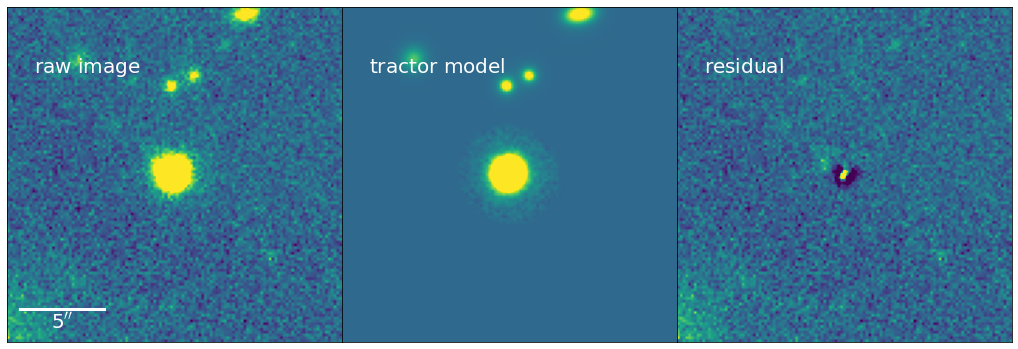

   The chi-square is 1.1593206


In [41]:
# Start fitting
# fitting in the i-band first: then pass the i-band parameters of target galaxy to other bands
model_dict = {}

ref_filt = 'i'
model_dict[ref_filt], _obj_cat_i = tractor_hsc_sep_blob_by_blob(
    obj, ref_filt, hsc_data.channels, hsc_data, 
    point_source=True,
    freeze_dict={'pos': False, 'shape': False, 'shape.re': False, 
                 'shape.ab': False, 'shape.phi': False, 'sersicindex': False}, # don't fix shape/sersic
    verbose=True, show_fig=True)

In [42]:
temp = model_dict[ref_filt].catalog.copy()
temp = temp[model_dict[ref_filt].target_ind:model_dict[ref_filt].target_ind+1]
# src.brightness.val *= 10**(0.4 * (obj['gaap_mag_1p0'].data[2] - obj['gaap_mag_1p0'].data[0]))

### `1832` i-band
# Total number of objects: 5
# Central object index in i-band: 0
# Global optimization: Chi2 improvement =  0.0


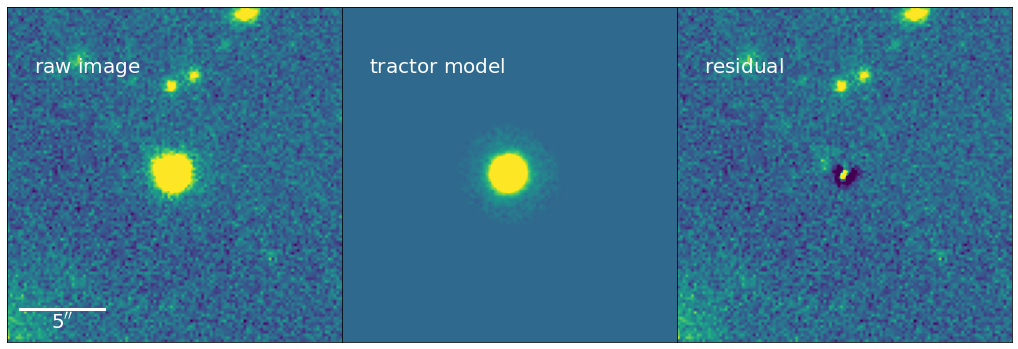

   The chi-square is 1.4654374


In [43]:
# Fix-all mode
model_dict['i'], _ = tractor_hsc_sep_blob_by_blob(
    obj, 'i', hsc_data.channels, hsc_data, 
    fix_all=True, tractor_cat=copy.deepcopy(temp),
    obj_cat=_obj_cat_i,
#     point_source=True,
#   ref_source=None,
#   freeze_dict={'pos': False, 'shape.re': False, 'shape.ab': False, 'shape.phi': False, 'sersicindex': False}, 
    freeze_dict={'pos': True, 'shape': True, 'shape.re': True, 
                 'shape.ab': True, 'shape.phi': True, 'sersicindex': True},  
    verbose=True, show_fig=True)

### `1832` g-band
# Total number of objects: 5
# Central object index in g-band: 0
# Global optimization: Chi2 improvement =  73.99262


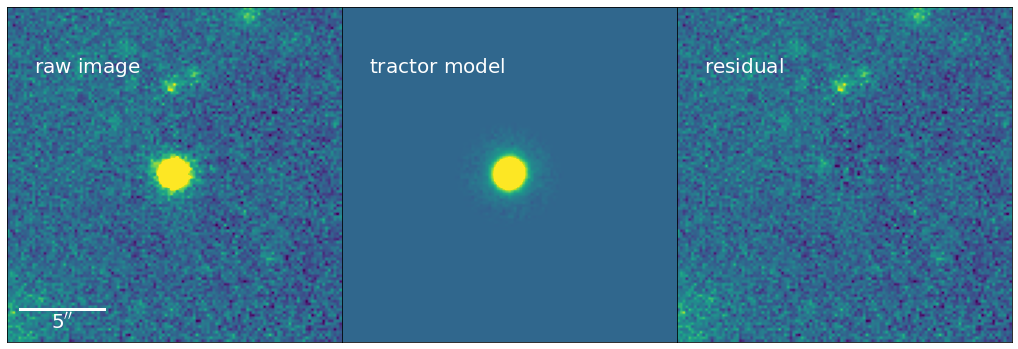

   The chi-square is 1.1690304


In [44]:
# Fix-all mode
model_dict['g'], _ = tractor_hsc_sep_blob_by_blob(
    obj, 'g', hsc_data.channels, hsc_data, 
    fix_all=True, tractor_cat=copy.deepcopy(temp),
    obj_cat=_obj_cat_i,
#     point_source=True,
#   ref_source=None,
#   freeze_dict={'pos': False, 'shape.re': False, 'shape.ab': False, 'shape.phi': False, 'sersicindex': False}, 
    freeze_dict={'pos': True, 'shape': True, 'shape.re': True, 
                 'shape.ab': True, 'shape.phi': True, 'sersicindex': True},  
    verbose=True, show_fig=True)

In [45]:
model_dict['i'].catalog, model_dict['g'].catalog

(Catalog[58.75608061428016, 59.20166629559551, 495.8653469399028],
 Catalog[58.73684967545012, 59.2362852761227, 137.1776800769353])

In [46]:
import copy
ref_source = copy.deepcopy(temp[0])
# Translate HSC coordinates into Merian coordinates
x, y = merian_data.wcs.wcs_world2pix(*hsc_data.wcs.wcs_pix2world(ref_source.pos.x, ref_source.pos.y, 0), 0)
ref_source.pos.x = float(x)
ref_source.pos.y = float(y)
# ref_source.shape.re *= 0.168 / 0.27 # to Merian pixel scale

In [47]:
for filt in merian_channels:
    pos = True
    fix_all = True
    print('filt = ', filt)
    model_dict[filt], _ = tractor_hsc_sep_blob_by_blob(
        obj, filt, merian_data.channels, merian_data,
        fix_all=fix_all, tractor_cat=[copy.deepcopy(ref_source)],
        obj_cat=_obj_cat_i,
        freeze_dict={'pos': pos, 'shape': True, 'shape.re': True, 'shape.ab': True, 'shape.phi': True,
                     'sersicindex': True},  # don't fix shape/sersic
        verbose=False)

filt =  N708
# Global optimization: Chi2 improvement =  10.165492
   The chi-square is 1.7113502
filt =  N540
# Global optimization: Chi2 improvement =  101.198524
   The chi-square is 1.4236374


### `1832` N708-band
# Total number of objects: 5
# Central object index in N708-band: 0
# Global optimization: Chi2 improvement =  10.165492


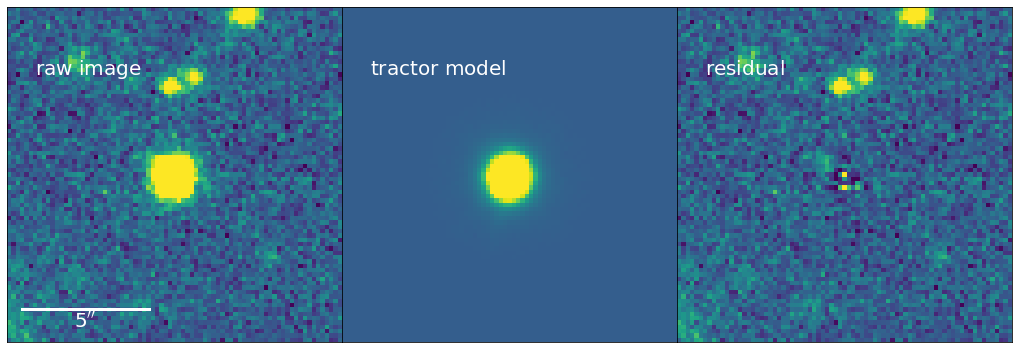

   The chi-square is 1.7113502


In [48]:
# Fix-all mode
model_dict['N708'], _ = tractor_hsc_sep_blob_by_blob(
    obj, 'N708', merian_data.channels, merian_data, 
    fix_all=True, tractor_cat=[copy.deepcopy(ref_source)],
    obj_cat=_obj_cat_i,
    point_source=False,
#   ref_source=None,
#   freeze_dict={'pos': False, 'shape.re': False, 'shape.ab': False, 'shape.phi': False, 'sersicindex': False}, 
    freeze_dict={'pos': True, 'shape': True, 'shape.re': True, 
                 'shape.ab': True, 'shape.phi': True, 'sersicindex': True}, 
    # Since the coordinate system of Merian is different from HSC, we don't fix position. 
    verbose=True, show_fig=True)

### `1832` N540-band
# Total number of objects: 5
# Central object index in N540-band: 0
# Global optimization: Chi2 improvement =  101.198524


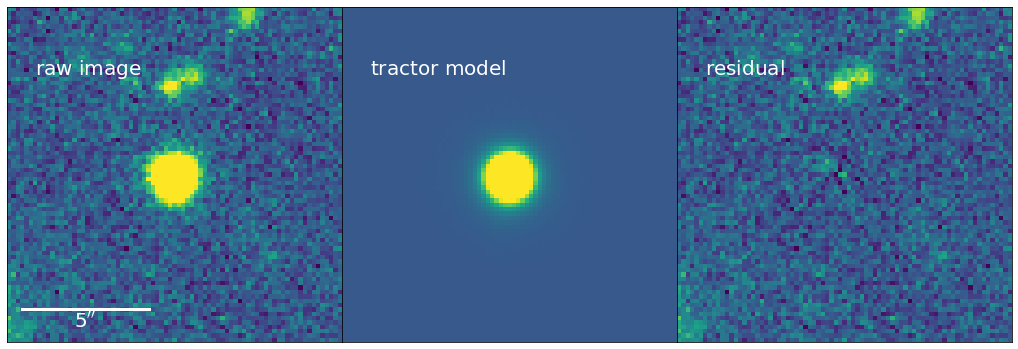

   The chi-square is 1.4236374


In [49]:
# Fix-all mode
model_dict['N540'], _ = tractor_hsc_sep_blob_by_blob(
    obj, 'N540', merian_data.channels, merian_data, 
    fix_all=True, tractor_cat=[copy.deepcopy(ref_source)],
    obj_cat=_obj_cat_i,
    point_source=True,
#   ref_source=None,
#   freeze_dict={'pos': False, 'shape.re': False, 'shape.ab': False, 'shape.phi': False, 'sersicindex': False}, 
    freeze_dict={'pos': True, 'shape': True, 'shape.re': True, 
                 'shape.ab': True, 'shape.phi': True, 'sersicindex': True}, 
    # Since the coordinate system of Merian is different from HSC, we don't fix position. 
    verbose=True, show_fig=True)

In [50]:
-2.5 * np.log10(getTargetProperty(model_dict['g'], target_ind=0
                                 )['flux'] / getTargetProperty(model_dict['i'], target_ind=0)['flux'])

1.3952007630809848

In [53]:
obj['gaap_mag_1p0'][0] - obj['gaap_mag_1p0'][2]

1.3752713174906646

In [52]:
2.5 * np.log10(getTargetProperty(model_dict['N708'], target_ind=0
                                )['flux'] / getTargetProperty(model_dict['i'], target_ind=0)['flux'])

-0.14308992252576888

# Batch fitting (forced-photometry, blob-by-blob)

In [84]:
from kuaizi.tractor.utils import initialize_meas_cat, _write_to_row, getTargetProperty

In [178]:
np.where(obj_cat['name'].data == 15833)

(array([31]),)

### Tractor modeling for obj 0
### `15833` i-band
    Detected 10 objects
# Total number of objects: 10
# Central object index in i-band: 0
# Progress: 1 / 10
# Progress: 2 / 10
# Progress: 3 / 10
# Progress: 4 / 10
# Progress: 5 / 10
# Progress: 6 / 10
# Progress: 7 / 10
# Progress: 8 / 10
# Progress: 9 / 10
# Progress: 10 / 10
# Global optimization: Chi2 improvement =  0.06064999


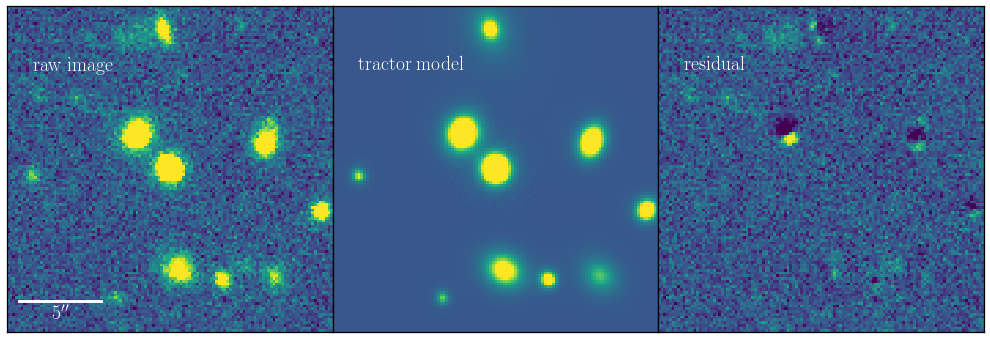

   The chi-square is 1.2804078
[PointSource(PixPos[59.143498855355816, 58.93454560701728], Flux(111.89102448763063))]
### `15833` g-band
# Total number of objects: 10
# Central object index in g-band: 0
# Global optimization: Chi2 improvement =  6.078677


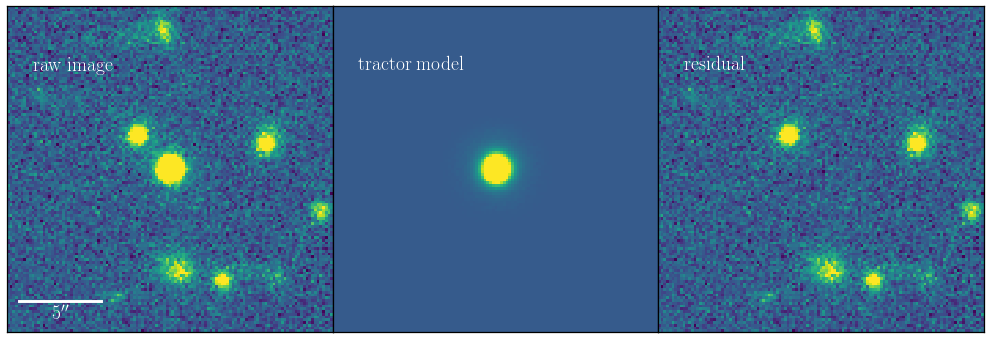

   The chi-square is 2.0260246
PointSource at pixel (59.15, 58.96) with Flux: 57.358
### `15833` r-band
# Total number of objects: 10
# Central object index in r-band: 0
# Global optimization: Chi2 improvement =  1.4206209


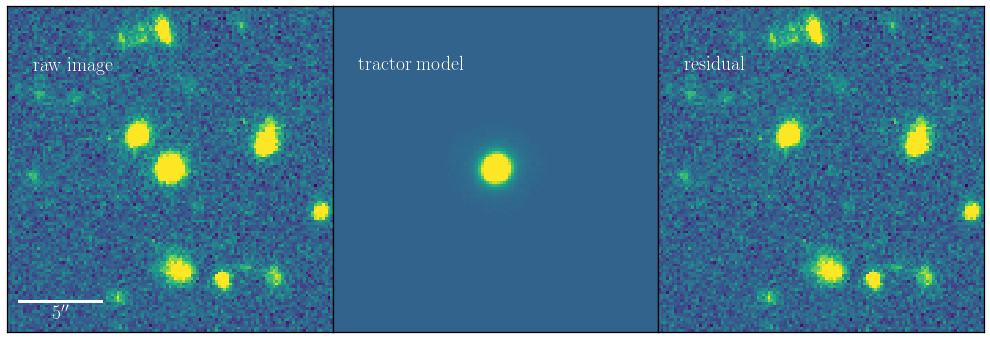

   The chi-square is 5.6956153
PointSource at pixel (59.13, 58.94) with Flux: 92.3114
### `15833` i-band
# Total number of objects: 10
# Central object index in i-band: 0
# Global optimization: Chi2 improvement =  7.867813e-05


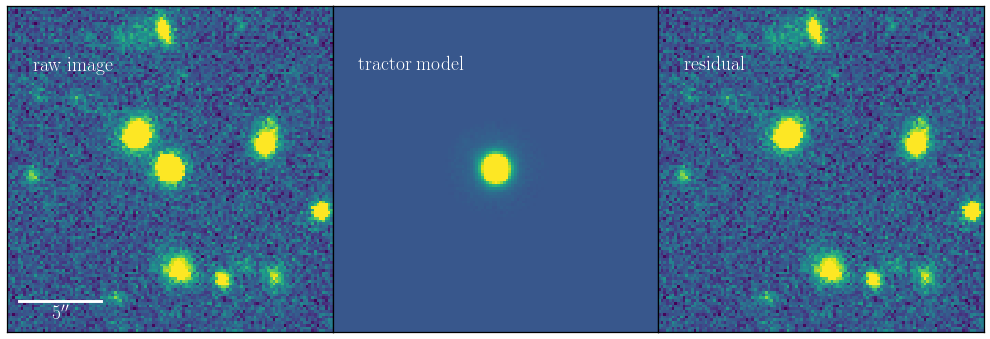

   The chi-square is 7.244588
PointSource at pixel (59.14, 58.94) with Flux: 112.051
### `15833` z-band
# Total number of objects: 10
# Central object index in z-band: 0
# Global optimization: Chi2 improvement =  0.05224371


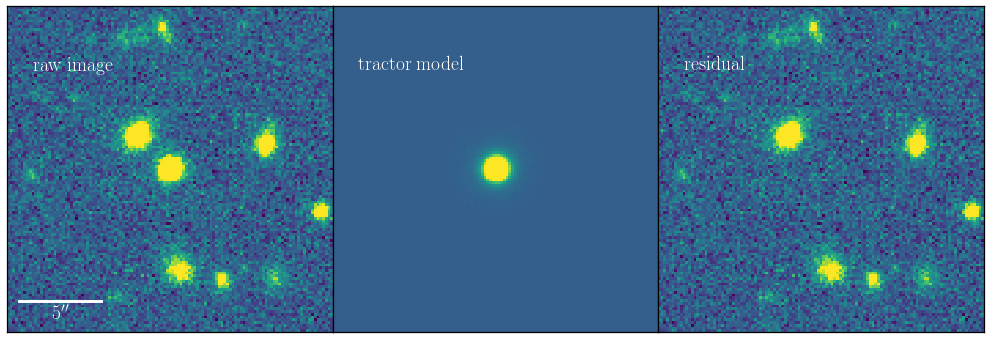

   The chi-square is 4.2169647
PointSource at pixel (59.14, 58.92) with Flux: 121.015
### `15833` y-band
# Total number of objects: 10
# Central object index in y-band: 0
# Global optimization: Chi2 improvement =  0.040662408


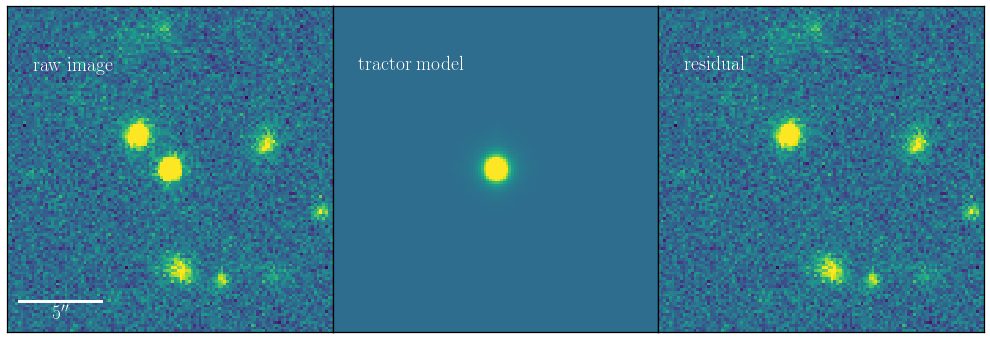

   The chi-square is 1.9770626
PointSource at pixel (59.17, 58.89) with Flux: 130.302
### `15833` N708-band
# Total number of objects: 10
# Central object index in N708-band: 0
# Global optimization: Chi2 improvement =  0.031226635


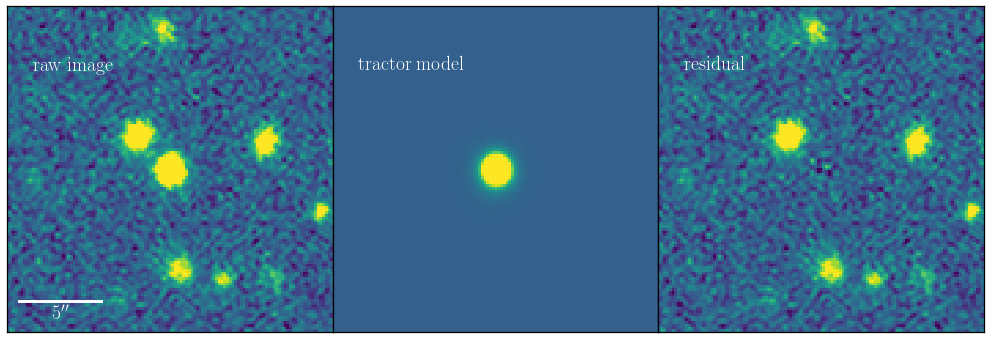

   The chi-square is 3.1288784
PointSource at pixel (59.23, 58.87) with Flux: 106.413
### `15833` N540-band
# Total number of objects: 10
# Central object index in N540-band: 0
# Global optimization: Chi2 improvement =  1.4846082


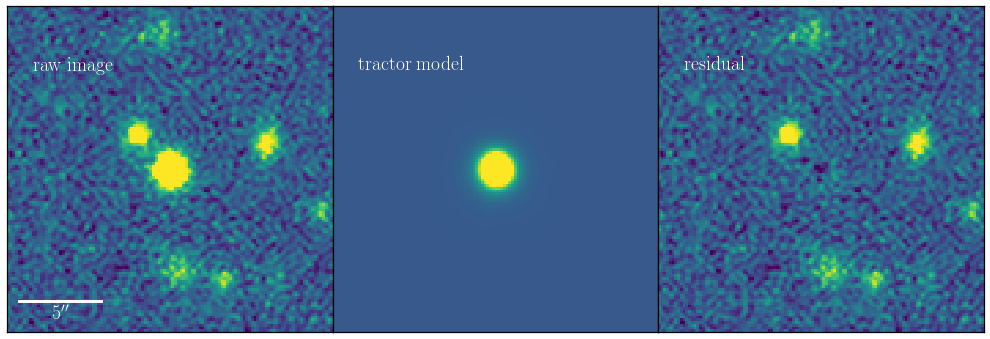

   The chi-square is 1.8059678
PointSource at pixel (59.22, 58.92) with Flux: 72.2255


In [179]:
channels = list('grizy') + ['N708', 'N540']
point_source=True

ref_filt = 'i'
forced_channels = channels #[filt for filt in channels if filt != ref_filt]

for k, obj in enumerate(obj_cat[31:31+1]):
    print(f'### Tractor modeling for obj {k}')
    obj_id = obj['id']
    
    cutout = []
    for filt in channels:
        cutout.append(fits.open(os.path.join(obj['dir'], f"{obj['prefix']}_{filt}_deepCoadd_calexp.fits")))

    psf_list = []
    for filt in channels:
        psf_list.append(fits.open(os.path.join(obj['dir'], f"{obj['prefix']}_{filt}_psf.fits")))

    coord = SkyCoord(obj['ra'], obj['dec'], frame='icrs', unit='deg')

    # Reconstruct data
    from kuaizi.detection import Data
#     from kuaizi.utils import padding_PSF

    images = np.array([hdu[1].data for hdu in cutout if len(hdu) > 1])
    w = wcs.WCS(cutout[0][1].header) # note: all bands share the same WCS here
    filters = list(channels)
    weights = 1 / np.array([hdu[3].data for hdu in cutout])
    psf_pad = [padding_PSF(_psf) for _psf in psf_list]
    #padding_PSF(psf_list) # Padding PSF cutouts from HSC
    data = Data(images=images, weights=weights, wcs=w, psfs=psf_pad, channels=channels)
    
    # Start fitting
    model_dict = {}
    # fitting in the i-band first: then pass the i-band parameters of target galaxy to other bands 
    model_dict[ref_filt], _obj_cat_i = tractor_hsc_sep_blob_by_blob(
        obj, ref_filt, data.channels, data, 
        point_source=point_source,
        freeze_dict={'pos': False, 'shape': False, 'shape.re': False, 
                     'shape.ab': False, 'shape.phi': False, 'sersicindex': False}, # don't fix shape/sersic
        verbose=True, show_fig=True)

    temp = model_dict[ref_filt].catalog.copy()
#         src = temp[model_dict[ref_filt].target_ind]
#         src.brightness.val *= 0.3 #10**(0.4 * (obj['gaap_mag_1p0'].data[2] - obj['gaap_mag_1p0'].data[k]))
    temp = temp[model_dict[ref_filt].target_ind:model_dict[ref_filt].target_ind+1]
    print(temp)
    for k, filt in enumerate(forced_channels):
        pos = True
        fix_all = True
#         ref_catalog = model_dict[ref_filt].catalog.copy()
#         ref_catalog[model_dict[ref_filt].target_ind].brightness.val *= 0.1
        model_dict[filt], _ = tractor_hsc_sep_blob_by_blob(
            obj, filt, data.channels, data,
            fix_all=fix_all, tractor_cat=copy.deepcopy(temp),
            obj_cat=_obj_cat_i,
            point_source=True,
            freeze_dict={'pos': True, 'shape': True, 'shape.re': True, 'shape.ab': True, 'shape.phi': True,
                         'sersicindex': True},  # don't fix shape/sersic
            verbose=True, show_fig=True)
        print(model_dict[filt].catalog[0])
#     with open(f'./cosmos_{obj["id"]}_tractor.pkl', 'wb') as f:
#         pickle.dump(model_dict, f)
    # Write to catalog
#     with open(obj_name + '_sep_tractor.pkl', 'wb') as f:
#         pickle.dump(model_dict, f)

In [180]:
meas_cat = Table.read('./Catalogs/stars/tractor_stars_output_0_500_ref_i.fits')

In [181]:
row = meas_cat[0]

In [182]:
from kuaizi.tractor.utils import _write_to_row

In [190]:
-2.5 * np.log10(112.0505743589707) + 27

21.87646478244318

In [189]:
model_dict

{'i': Tractor[0.0, 59.141642251363265, 58.93675804870432, 112.0505743589707],
 'g': Tractor[0.0, 59.14884624501904, 58.96436507059248, 57.35798658036762],
 'r': Tractor[0.0, 59.131167664257916, 58.940837853398214, 92.31137626079071],
 'z': Tractor[0.0, 59.14249322784576, 58.921143280272744, 121.01487125812838],
 'y': Tractor[0.0, 59.168190735534196, 58.88750032295728, 130.30219190485644],
 'N708': Tractor[0.0, 59.23497059778662, 58.86873928688954, 106.4130727562725],
 'N540': Tractor[0.0, 59.22000860976433, 58.92490431040474, 72.22549273713116]}

In [183]:
row = _write_to_row(row, model_dict, channels=channels)

In [188]:
-2.5 * np.log10(row['flux']) + 22.5

array([22.60351525, 22.08686194, 21.87646478, 21.79290314, 21.7126207 ,
       21.93251254, 22.35327372])

In [ ]:
22.229086455433904, 21.71111650359827,
                   21.502729023858024, 21.41409676186374,
                   21.362682131236955, 21.53748058863566,
                   21.970312217024812

In [176]:
21.11042888 - 21.25884675

-0.1484178699999994

In [177]:
Table.read('./Catalogs/stars/tractor_stars_output_0_500.fits')['flux']

2.1725597023534116 .. 3.429933993812649
11.40506156155167 .. 14.947064712220458
2.744386137777621 .. 3.5260869234964742
4.066637865078134 .. 5.805637820674579
4.70152407373537 .. 5.753279889141336
1.8283955509480854 .. 3.002002156893822
2.6959986122978905 .. 4.7438445171368455
14.122269188097032 .. 15.43312663957474
15.418449597311616 .. 18.664456896574336
7.885383347353892 .. 9.649321033998751
1.1435265915466897 .. 1.3245082006444402


In [126]:
row['flux']

array([1.38142252, 1.38142252, 1.38142252, 1.38142252, 1.38142252,
       1.38142252, 1.38142252])

In [162]:
import copy

In [102]:
-2.5 * np.log10(getTargetProperty(model_dict['g'])['flux'] / getTargetProperty(model_dict['i'])['flux'])

0.4931064639168201

In [103]:
-2.5 * np.log10(getTargetProperty(model_dict['z'])['flux'] / getTargetProperty(model_dict['i'])['flux'])

-0.02274338051167689

In [105]:
2.5 * np.log10(getTargetProperty(model_dict['N708'])['flux'] / getTargetProperty(model_dict['i'])['flux'])

-0.0545701394914844

---

In [62]:
import sys
sys.path.append('/home/jiaxuanl/Research/Merian/merian_tractor/scripts/')
sys.path.append('/home/jiaxuanl/Research/Packages/carpenter/src/')
import kuaizi
kuaizi.set_matplotlib(style='JL', usetex=True, dpi=70)
from carpenter.display import display_merian_cutout_rgb, SBP_single
from carpenter.utils import SBP_star

In [98]:
# Visualize our model
channels = list('griz') + ['N708', 'N540']
from kuaizi.tractor.utils import HiddenPrints
with HiddenPrints():
    model_img = np.asarray([
        model_dict[key].getModelImage(
            0, srcs=model_dict[key].catalog[model_dict[key].target_ind:model_dict[key].target_ind+1]
                                     ) for key in channels])

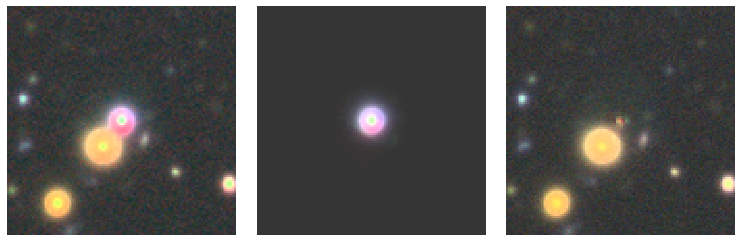

In [99]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(11, 5))

Q = 1.5
stretch = 0.7

_img = np.vstack([data.images[0:4], data.images[-2:]])
_, img_rgb = display_merian_cutout_rgb(_img, filters=list('griz') + ['N708', 'N540'], 
                          ax=ax1, color_norm=None, Q=Q, stretch=stretch, 
                          channel_map=None, N708_strength=3);

_, _ = display_merian_cutout_rgb(model_img, filters=list('griz') + ['N708', 'N540'], 
                                 ax=ax2, Q=Q, stretch=stretch, 
                                 color_norm=None,
                                 channel_map=None);

_, _ = display_merian_cutout_rgb(_img - model_img, filters=list('griz') + ['N708', 'N540'], 
                                 ax=ax3, Q=Q, stretch=stretch, 
                                       color_norm=None,
                                       channel_map=None);

plt.subplots_adjust(wspace=0.03)
plt.tight_layout()
# plt.savefig(f"/tigress/jiaxuanl/public_html/Merian/stars/{obj['prefix']}_tractor.png")

In [89]:
obj

name,prefix,dir,chunk,ra,dec,half_size,id
,,,,,,arcsec,
int64,bytes12,bytes57,int64,float64,float64,float64,int64
90906,stars_90906,/scratch/gpfs/jiaxuanl/Data/Merian/Cutout/stars/27/90906,27,150.18226146195155,1.6341651995772444,10.0,90906


In [12]:
### SBP

In [13]:
isolist_dict = {}
for ind in [2, 5, 6]:
    isolist_dict[ind] = SBP_star(model_dict, data, ind=ind)

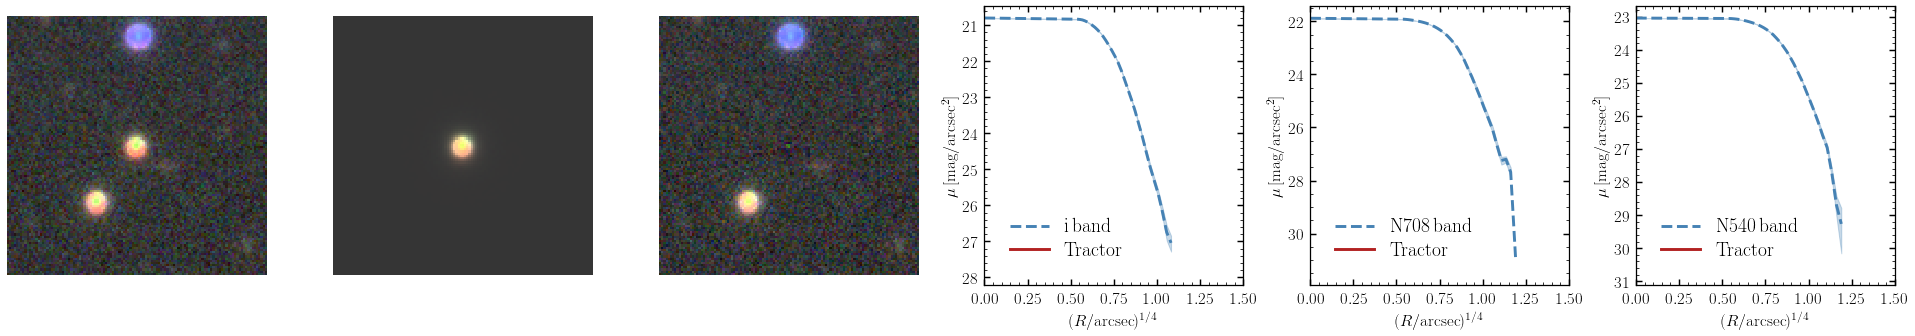

In [16]:
fig, axes = plt.subplots(1, 6, figsize=(27.5, 5), constrained_layout=True)

Q = 1.5
stretch = 0.7

_img = np.vstack([data.images[0:4], data.images[-2:]])
_, img_rgb = display_merian_cutout_rgb(_img, filters=list('griz') + ['N708', 'N540'], 
                          ax=axes[0], color_norm=None, Q=Q, stretch=stretch, 
                          channel_map=None, N708_strength=3);

_, _ = display_merian_cutout_rgb(model_img, filters=list('griz') + ['N708', 'N540'], 
                                 ax=axes[1], Q=Q, stretch=stretch, 
                                 color_norm=None,
                                 channel_map=None);

_, _ = display_merian_cutout_rgb(_img - model_img, filters=list('griz') + ['N708', 'N540'], 
                                 ax=axes[2], Q=Q, stretch=stretch, 
                                       color_norm=None,
                                       channel_map=None);

ax = axes[3]
(isolist_model, isolist_data) = isolist_dict[2]
ax = SBP_single(isolist_data.to_table(), None, 0.168, 27.0, x_min=0.0, x_max=1.5, 
                ax=ax, label='i\,band', linecolor='steelblue', linestyle='--');
ylim = ax.get_ylim()
ylim = (ylim[0]+ 0.6, ylim[1])
ax = SBP_single(isolist_model.to_table(), None, 0.168, 27.0, 
                x_min=0.0, x_max=1.5, ax=ax, label='Tractor', alpha=0.5);
ax.set_ylim(*ylim)

ax = axes[4]
(isolist_model, isolist_data) = isolist_dict[5]
ax = SBP_single(isolist_data.to_table(), None, 0.168, 27.0, x_min=0.0, x_max=1.5, 
                ax=ax, label='N708\,band', linecolor='steelblue', linestyle='--');
ylim = ax.get_ylim()
ylim = (ylim[0]+ 0.6, ylim[1])
ax = SBP_single(isolist_model.to_table(), None, 0.168, 27.0, 
                x_min=0.0, x_max=1.5, ax=ax, label='Tractor', alpha=0.5);
ax.set_ylim(*ylim)

ax = axes[5]
(isolist_model, isolist_data) = isolist_dict[6]
ax = SBP_single(isolist_data.to_table(), None, 0.168, 27.0, x_min=0.0, x_max=1.5, 
                ax=ax, label='N540\,band', linecolor='steelblue', linestyle='--');
ylim = ax.get_ylim()
ylim = (ylim[0]+ 0.6, ylim[1])
ax = SBP_single(isolist_model.to_table(), None, 0.168, 27.0, 
                x_min=0.0, x_max=1.5, ax=ax, label='Tractor', alpha=0.5);
ax.set_ylim(*ylim)

fig.tight_layout()
plt.savefig(f"/tigress/jiaxuanl/public_html/Merian/stars/{obj['prefix']}_tractor.png")

In [142]:
from kuaizi.tractor.utils import HiddenPrints
from photutils.isophote import Ellipse, EllipseGeometry
from photutils.aperture import EllipticalAperture

In [202]:
from carpenter.utils import mask_image
mask = mask_image(data.images[0])

gal = model_dict['i'].catalog[model_dict['i'].target_ind]
geometry = EllipseGeometry(x0=_mean_x, 
                           y0=_mean_y, 
                           sma=1, eps=0,
                           pa=0)

ellipse = Ellipse(data.images[0] * (~mask), geometry)
# isolist_data = ellipse.fit_image(
#                              nclip=3, maxgerr=2.0,
#                              fix_center=False, fix_pa=True, fix_eps=True)

### Comparison

In [25]:
meas_cat = Table.read('./Catalogs/stars/tractor_stars_output_0_500.fits')

In [26]:
meas_cat['mag'] = 22.5 - 2.5 * np.log10(meas_cat['flux'])

In [27]:
gaap_cat = Table.read('./Cutout/stars/stars_obj_cat.fits')

In [28]:
channels = list('grizy') + ['N708', 'N540']

In [29]:
for aper in ['1p0', '1p5', '2p5', '3p0', 'Optimal']:
    gaap_cat[f'gaap_mag_{aper}'] = np.hstack(
        [31 - 2.5 * np.log10(gaap_cat[f'{filt}_gaap{aper}Flux'].data[:, None]
                            ) for filt in list('grizy') + ['N708', 'N540']])

In [30]:
gaap_cat[f'psf_mag'] = np.hstack(
        [31 - 2.5 * np.log10(gaap_cat[f'{filt}_psfFlux'].data[:, None]
                            ) for filt in list('grizy') + ['N708', 'N540']])

In [31]:
gaap_cat[f'cmodel_mag'] = np.hstack(
        [31 - 2.5 * np.log10(gaap_cat[f'{filt}_cModelFlux'].data[:, None]
                            ) for filt in list('grizy') + ['N708', 'N540']])

In [32]:
kuaizi.set_matplotlib(style='JL', usetex=True, dpi=80)

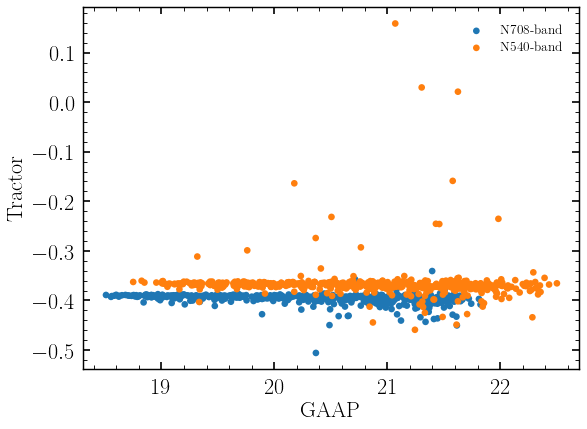

In [382]:
fig, ax = plt.subplots(figsize=(8, 6))
for i in range(5,7):
    filt = channels[i]
    plt.scatter(gaap_cat['gaap_mag_1p0'][:, i], 
                gaap_cat['gaap_mag_1p0'][:, i] - meas_cat['mag'][:, i], edgecolors='none',
                label=f'{filt}-band')

plt.xlabel('GAAP')
plt.ylabel('Tractor')
plt.legend(fontsize=12)

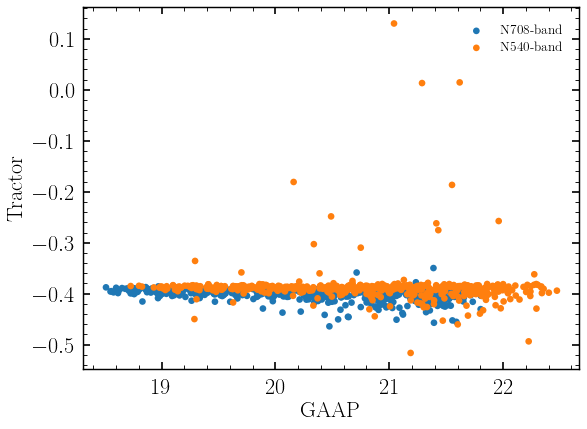

In [389]:
fig, ax = plt.subplots(figsize=(8, 6))
for i in range(5,7):
    filt = channels[i]
    plt.scatter(gaap_cat['cmodel_mag'][:, i], 
                gaap_cat['cmodel_mag'][:, i]- meas_cat['mag'][:, i], edgecolors='none',
                label=f'{filt}-band')

plt.xlabel('GAAP')
plt.ylabel('Tractor')
plt.legend(fontsize=12)

In [35]:
kuaizi.set_matplotlib()

Text(0.5, 0.95, 'GAAP 1p0 (x) v.s. Tractor (y)')

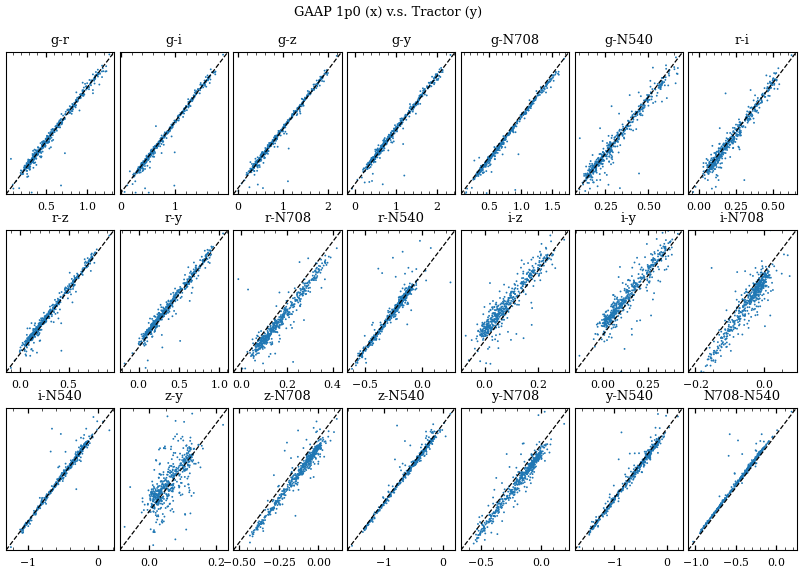

In [36]:
from itertools import combinations
fig, axes = plt.subplots(3, 7, figsize=(17, 11))

for i, (filt1, filt2) in enumerate(combinations(range(len(channels)), 2)):
    plt.sca(axes[i // 7, i % 7])
    aper = '1p0'
    color1 = gaap_cat[f'gaap_mag_{aper}'][:, filt1] - gaap_cat[f'gaap_mag_{aper}'][:, filt2]
    color2 = meas_cat['mag'][:, filt1] - meas_cat['mag'][:, filt2]
    plt.scatter(color1, color2,
                s=5,
                label=aper, edgecolors='none')

    xlim = plt.gca().get_xlim()
    x = np.linspace(*xlim, 2)
    plt.plot(x, x, color='k', ls='--')
    plt.xlim(*xlim)
    plt.ylim(*xlim)
    plt.yticks([])
    plt.title(channels[filt1] + '-' + channels[filt2])
    
plt.subplots_adjust(wspace=0.05, hspace=0.25)
plt.suptitle('GAAP 1p0 (x) v.s. Tractor (y)', y=0.95)

Text(0.5, 0.95, 'GAAP 1p0 (x) v.s. PSF mag (y)')

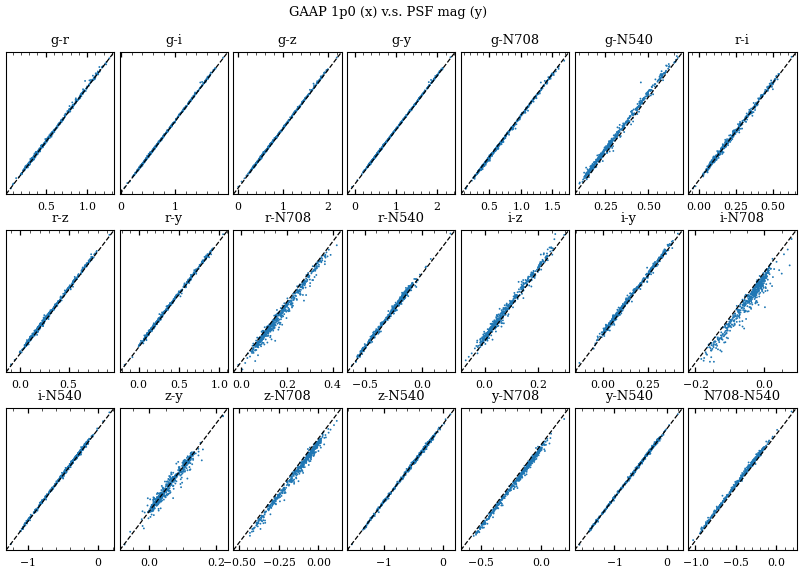

In [37]:
from itertools import combinations
fig, axes = plt.subplots(3, 7, figsize=(17, 11))

for i, (filt1, filt2) in enumerate(combinations(range(len(channels)), 2)):
    plt.sca(axes[i // 7, i % 7])
    aper = '1p0'
    color1 = gaap_cat[f'gaap_mag_{aper}'][:, filt1] - gaap_cat[f'gaap_mag_{aper}'][:, filt2]
    
#     color2 = gaap_cat['cmodel_mag'][:, filt1] - gaap_cat["cmodel_mag"][:, filt2]
    color2 = gaap_cat['psf_mag'][:, filt1] - gaap_cat["psf_mag"][:, filt2]
#     color2 = meas_cat['mag'][:, filt1] - meas_cat['mag'][:, filt2]
    plt.scatter(color1, color2,
                s=5,
                label=aper, edgecolors='none')

    xlim = plt.gca().get_xlim()
    x = np.linspace(*xlim, 2)
    plt.plot(x, x, color='k', ls='--')
    plt.xlim(*xlim)
    plt.ylim(*xlim)
    plt.yticks([])
    plt.title(channels[filt1] + '-' + channels[filt2])
    
plt.subplots_adjust(wspace=0.05, hspace=0.25)
plt.suptitle('GAAP 1p0 (x) v.s. PSF mag (y)', y=0.95)

Text(0.5, 0.92, 'Stars')

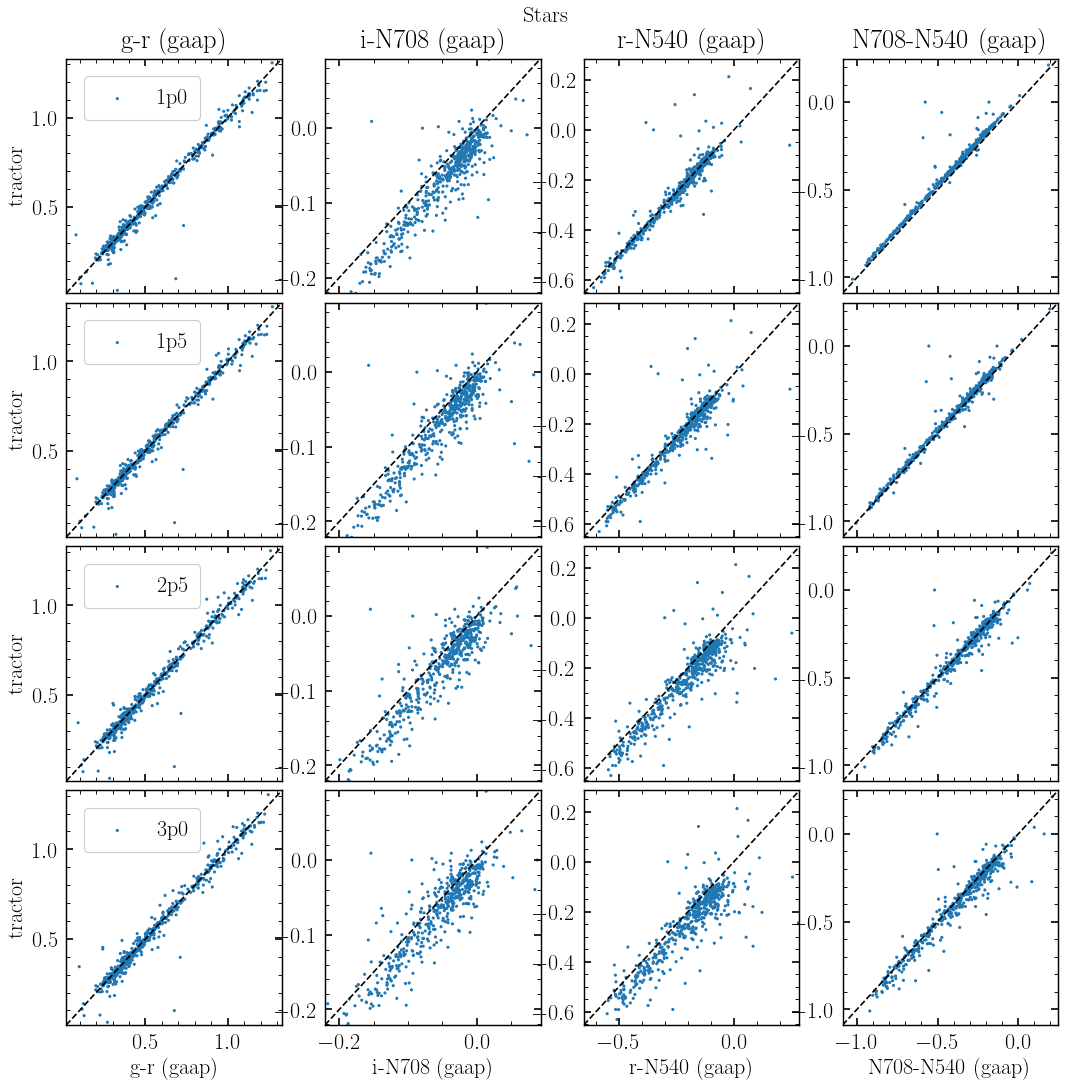

In [350]:
fig, axes = plt.subplots(4, 4, figsize=(16, 16), sharex='col')

_filt = ((0, 1), (2, 5), (1, 6), (5, 6))

_apers = ['1p0', '1p5', '2p5', '3p0']

for k, aper in enumerate(_apers):
    for i in range(4):
        plt.sca(axes[k, i])
#         aper = '1p5'
        filt1, filt2 = _filt[i]
        color1 = gaap_cat[f'gaap_mag_{aper}'][:, filt1] - gaap_cat[f'gaap_mag_{aper}'][:, filt2]
        color2 = meas_cat['mag'][:, filt1] - meas_cat['mag'][:, filt2]
        label = aper if i == 0 else None
        plt.scatter(color1, color2,
                    s=8,
                    label=label, edgecolors='none')

        xlim = plt.gca().get_xlim()
        x = np.linspace(*xlim, 2)
        plt.plot(x, x, color='k', ls='--')
        plt.xlim(*xlim)
        plt.ylim(*xlim)
        
        if i == 0:
            plt.legend(frameon=True)
        if k == 3:
            plt.xlabel(channels[filt1] + '-' + channels[filt2] + ' (gaap)')
        if k == 0:
            plt.title(channels[filt1] + '-' + channels[filt2] + ' (gaap)')
    axes[k, 0].set_ylabel('tractor')
    
plt.subplots_adjust(hspace=0.04)

plt.suptitle('Stars', y=0.92, fontsize=20)

In [351]:
gi_gaap = (gaap_cat['gaap_mag_1p0'][:, 2] - gaap_cat['gaap_mag_1p0'][:, 5])

In [352]:
gi_tractor = (meas_cat['mag'][:, 2] - meas_cat['mag'][:, 5])

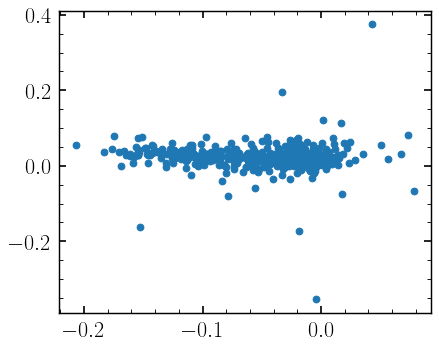

In [353]:
plt.scatter(gi_gaap, gi_gaap - gi_tractor)
# x = np.linspace(-0.2, 0.1)
# plt.plot(x, x)

In [360]:
(gi_gaap - gi_tractor)[159]

0.07504772806309035

In [336]:
np.where(((gi_gaap - gi_tractor) > 0.05) & (gi_gaap < -0.1))

(array([  5, 159, 226, 257, 266, 374, 379, 420, 440, 475, 497]),)